# Qual o hiato do produto no Brasil?

Uma medida extremamente importante para a avaliação econônomica de um país é o Hiato do Produto. Neste post, realizamos uma comparação das diferentes formas de estimação dessa variável não observável utilizando o Python como ferramenta de análise de dados.

# Introdução

A macroeconomia nasce da soma de milhões de decisões diárias de indivíduos descentralizados. Tais indivíduos, com necessidades ilimitadas, decidem todos os dias o que produzir, como produzir e como distribuir esse esforço produtivo.

A variável macroeconômica que representa esse esforço de forma mais completa é o que chamamos de produto interno bruto, ou simplesmente PIB, a soma de todos os bens e serviços finais produzidos por um país ao longo de um determinado período de tempo.

O PIB é, nesse contexto, uma medida, expressa em valores correntes ou números índices, do quanto um país utilizando recursos escassos, como trabalho e capital, gerou de produção e, consequentemente, de renda em um determinado período.

Não por outro motivo, a taxa de crescimento do PIB fornece uma boa medida sobre o quão rápido ou devagar um determinado país está se tornando mais desenvolvido.

De forma a definir o PIB em termos um pouco mais precisos, Considere que o PIB efetivamente observado (de agora em diante chamado de PIB efetivo) possa ser decomposto em duas partes, a saber:\begin{align}Y_{t} = Y^P_{t} + h_{t} \end{align} Onde $Y_{t}$ é o PIB em $t$, $Y^P_{t}$ é a tendência de longo prazo do PIB, chamada de produto potencial e $h_{t}$ é um componente cíclico, chamado de hiato do produto.

O PIB Potencial, $Y^P_{t}$, a tendência do PIB Efetivo ao longo do tempo, reflete condições estruturais da economia, como a população em idade ativa, o estoque de capital, qualidade da educação, qualidade das instituições, etc. O hiato do produto, $h_{t}$, o componente cíclico, por sua vez, reflete questões conjunturais, como incentivos de política econômica, condições climáticas, choques externos, incertezas políticas, etc.

Em outros termos, no curto prazo o PIB Efetivo pode crescer mais ou menos do que o PIB Potencial, aquela tendência. No longo prazo, entretanto, o crescimento da economia está limitado pela disponibilidade de fatores e pela forma como esses fatores são combinados.

Isto é, supondo que a estrutura da economia possa ser representada por uma função do tipo Cobb-Douglas, com retornos constantes de escala, temos que: \begin{align} Y_{t} = A_{t} K_{t}^{\alpha_{t}} L_{t}^{1-\alpha_{t}}\end{align} Onde $K_{t}$ e $L_{t}$ são, respectivamente, a quantidade de capital e trabalho, $A_{t}$ mede a eficiência tecnológica ou a produtividade total dos fatores e $\alpha_{t}$, por fim, mede a participação do capital na renda nacional.

Nesse contexto, $Y_{t}$, a soma de bens e serviços finais produzidos em determinado período de tempo, será dado pela combinação entre uma determinada quantidade de estoque de capital com outra de trabalho, moderada pela tecnologia disponível. Em última instância, portanto, $Y_{t}$ estará limitado pela disponibilidade de fatores de produção e pela forma como esses fatores são combinados a produtividade total dos fatores. Os economistas gostam de chamar essa limitação de produto potencial, ou simplesmente $Y^P_{t}$.

No curto prazo, a diferença entre $Y_{t}$ e $Y^P_{t}$ será assim dada pelo hiato do produto, $h_{t}$, que, por construção, irá medir o grau de ociosidade da economia.

Calcular o hiato do produto, entretanto, não é uma tarefa trivial, uma vez que o PIB potencial não é uma variável observável. Precisamos estimar o produto potencial e, depois, calcular o hiato.

Sendo assim, há três formas usuais de obter o Hiato do Produto:

- Extração de Tendência do PIB via MQO.

- Filtros Univariados e Multivariados, para extrair a tendência do PIB.

- Função de produção (descrita acima).

É importante destacar que nenhum método é perfeito, mas alguns são úteis para o próposito em questão. Sugere-se aqui obter diferentes tipos de Hiato, para realizar uma comparação abrangente, e compreender a incerteza relacionada à essa variável não observável.

Realizamos a comparação dos seguintes Hiatos do Produto:

- Tendência Linear (MQO)
- Tendência Quadrática (MQO)
- Filtro HP
- Filtro de Hamilton
- Hiato estimado pela Instituição Fiscal Independente
- Hiato estimado pelo Banco Central do Brasil

Para tanto, construímos o código em Python para criar as medidas de Hiato, exceto da IFI e BCB, que são importados de seus respectivos sites.

# Bibliotecas

In [ ]:
!pip install sidrapy --quiet

In [ ]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sidrapy as sidra
from plotnine import *

# Dados

In [ ]:
# Importar dados:
# PIB - Preços de mercado - Série encadeada s.a. - Índice (média 1995 = 100)
pib_bruto = sidra.get_table(
                table_code = 1621,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = 'all',
                period = "all",
                classifications = {"11255" : "90707"},
                header = 'n'
                )
pib = (
    pib_bruto
    [['D2C', 'V']]
    .rename(
        columns = {
            "D2C": "data",
            "V": "pib"
            }
            )
     .assign(  # substitui o 5º caracter da coluna data por "-Q" e converte em YYYY-MM-DD
        data = lambda x: pd.PeriodIndex(
            x.data.str.slice_replace(start = 4, stop = 5, repl = "-Q"),
            freq = "Q"
            ).to_timestamp(),
        pib = lambda x: x.pib.astype(float) # converte de texto para numérico
        )
)

# Cria novas colunas auxiliares para o exercício
pib["ln_pib"] = np.log(pib["pib"])  # Transformação logarítmica do PIB
pib["tempo"] = pib.index + 1        # Vetor de 1 até T indicando ordenação tempora das observações

pib.head()

,data,pib,ln_pib,tempo
0,1996-01-01,99.40,4.599152,1
1,1996-04-01,100.68,4.611947,2
2,1996-07-01,104.15,4.645832,3
3,1996-10-01,103.39,4.638508,4
4,1997-01-01,104.43,4.648517,5


# Tendência linear

In [ ]:
# Regressão linear do PIB contra o tempo
reg1 = smf.ols(
    formula = "ln_pib ~ tempo",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_tl = np.exp(reg1.predict()) # extrai os valores estimados e reverte a transformação logarítmica
potencial_tl

array([104.81126402, 105.39821189, 105.9884467 , 106.58198684,
       107.17885084, 107.7790573 , 108.38262495, 108.9895726 ,
       109.59991919, 110.21368375, 110.83088542, 111.45154344,
       112.07567718, 112.70330609, 113.33444976, 113.96912786,
       114.60736018, 115.24916664, 115.89456724, 116.54358211,
       117.1962315 , 117.85253575, 118.51251534, 119.17619084,
       119.84358296, 120.5147125 , 121.1896004 , 121.8682677 ,
       122.55073557, 123.23702529, 123.92715826, 124.62115601,
       125.31904018, 126.02083254, 126.72655496, 127.43622946,
       128.14987817, 128.86752334, 129.58918736, 130.31489274,
       131.04466209, 131.77851819, 132.51648391, 133.25858228,
       134.00483643, 134.75526964, 135.50990531, 136.26876697,
       137.0318783 , 137.79926308, 138.57094525, 139.34694888,
       140.12729816, 140.91201743, 141.70113117, 142.49466398,
       143.29264062, 144.09508595, 144.90202502, 145.71348298,
       146.52948515, 147.35005696, 148.17522402, 149.00

# Tendência quadrática

In [ ]:
# Regressão linear do PIB contra o tempo + tempo^2
reg2 = smf.ols(
    formula = "ln_pib ~ tempo + np.power(tempo, 2)",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_tq = np.exp(reg2.predict()) # extrai os valores estimados e reverte a transformação logarítmica
potencial_tq

array([ 95.25845836,  96.26252838,  97.26896237,  98.27761411,
        99.28833524, 100.30097536, 101.31538207, 102.33140092,
       103.34887553, 104.36764758, 105.38755685, 106.40844125,
       107.43013687, 108.45247803, 109.47529727, 110.49842545,
       111.52169175, 112.54492372, 113.56794734, 114.59058705,
       115.61266581, 116.63400511, 117.65442507, 118.67374445,
       119.69178072, 120.70835009, 121.72326758, 122.73634708,
       123.74740137, 124.75624222, 125.76268039, 126.76652575,
       127.76758728, 128.76567316, 129.76059082, 130.752147  ,
       131.74014781, 132.7243988 , 133.704705  , 134.680871  ,
       135.65270101, 136.61999892, 137.58256837, 138.5402128 ,
       139.49273555, 140.43993988, 141.38162906, 142.31760644,
       143.24767552, 144.17164   , 145.08930386, 146.00047143,
       146.90494745, 147.80253715, 148.6930463 , 149.5762813 ,
       150.45204925, 151.32015799, 152.18041622, 153.03263351,
       153.8766204 , 154.71218851, 155.53915051, 156.35

# Filtro HP

In [ ]:
# Calcula o filtro HP
filtro_hp = sm.tsa.filters.hpfilter(x = pib['ln_pib'], lamb = 1600)

# Salva a tendência calculada
potencial_hp = np.exp(filtro_hp[1]) # posição 1 é a tendência (0=ciclo); reverte a transformação logarítmica
potencial_hp.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format


,ln_pib_trend
0,101.492965
1,101.977348
2,102.462707
3,102.946872
4,103.428684


# Filtro de Hamilton

In [ ]:
# Regressão linear aplicando a especificação de Hamilton
reg3 = smf.ols(
    formula = "ln_pib ~ ln_pib.shift(8) + ln_pib.shift(9) + ln_pib.shift(10) + ln_pib.shift(11)",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_h = np.exp(reg3.predict()) # extrai os valores estimados e reverte a transformação logarítmica

# Adiciona 11 NaNs no início da série para corresponder ao tamanho da série do PIB
potencial_h = np.append([np.nan]*11, potencial_h)
potencial_h

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 110.66847085,
       112.36039945, 112.16014156, 113.62567223, 114.59419196,
       112.35293504, 114.47956359, 113.59705957, 113.13086602,
       113.14800829, 113.40780392, 113.66535902, 115.25720045,
       116.24986706, 117.92339134, 119.32698391, 120.60313756,
       120.85584748, 120.39783328, 119.77903173, 119.18813226,
       122.18742528, 122.23157536, 124.37726827, 125.03855606,
       124.7103089 , 123.75762775, 124.68688109, 125.69146691,
       127.71831621, 130.9824874 , 132.42381704, 133.650771  ,
       134.45921305, 135.70046287, 134.91633295, 136.84115597,
       138.27852821, 139.04151914, 141.40744403, 142.66089827,
       145.3017388 , 147.52426894, 148.96601073, 151.07733459,
       152.7368862 , 155.76638292, 157.84008674, 152.04319576,
       150.64588841, 152.15942743, 155.79943768, 160.07

# Hiato IFI



In [ ]:
# Coleta e tratamento do Hiato do Produto da IFI
hiato_ifi = (
    pd.read_excel(
    "https://www12.senado.leg.br/ifi/dados/arquivos/estimativas-do-hiato-do-produto-ifi.xlsx",
    sheet_name = "Hiato do Produto",
    skiprows = 1
    )
    .assign(data = lambda x: pd.to_datetime(x['Trim-Ano']).dt.to_period('Q'),
            IFI = lambda x: x.Hiato.astype(float) * 100)
    .loc[:, ['data', 'IFI']]
  )

hiato_ifi.head()

,data,IFI
0,1996Q1,-1.32
1,1996Q2,-0.89
2,1996Q3,1.51
3,1996Q4,0.43
4,1997Q1,0.97


# Hiato BCB

In [ ]:
# Coleta e tratamento do Hiato do Produto do BCB
hiato_bcb = (
    pd.read_excel(
    "https://www.bcb.gov.br/content/ri/relatorioinflacao/202509/rpm202509anp.xlsx",
    sheet_name = "Graf 2.2.8",
    skiprows = 8
    )
    .assign(data = lambda x: pd.to_datetime(x['Trimestre']).dt.to_period('Q'),
            BCB = lambda x: x["Cenário de referência"].astype(float))
    .loc[:, ['data', 'BCB']]
    .dropna()
  )

hiato_bcb.head()

,data,BCB
1,2003Q4,-0.99
2,2004Q1,-0.54
3,2004Q2,-0.11
4,2004Q3,0.27
5,2004Q4,0.49


# Calculando o hiato

In [ ]:
# Cálculo do hiato do produto
dados = pib[["data", "pib"]].copy()  # seleciona colunas de interesse
dados["Tendência Linear"] = (dados["pib"] / potencial_tl - 1) * 100    # cria novas colunas com cálculo do hiato
dados["Tendência Quadrática"] = (dados["pib"] / potencial_tq - 1) * 100
dados["Filtro HP"] = (dados["pib"] / potencial_hp - 1) * 100
dados["Filtro de Hamilton"] = (dados["pib"] / potencial_h - 1) * 100
dados['data'] = dados.data.dt.to_period('Q')
dados = pd.merge(dados, hiato_ifi, on='data', how='outer')
dados = pd.merge(dados, hiato_bcb, on='data', how='outer')

In [ ]:
dados = dados.drop(columns = ["pib"])  # remove a coluna da série do PIB
dados_long = dados.melt(    # transforma a tabela pro formato "longo" (mais linhas e menos colunas)
    id_vars = ["data"],  # coluna identificadora das observações (todas as demais serão transformadas)
    value_name = "valor", # nome da coluna que armazenará os nomes das colunas transformadas
    var_name = "variavel" # nome da coluna que armazenará os valores das colunas transformadas
    )
dados_long['data'] = dados_long.data.dt.to_timestamp()
dados_long

,data,variavel,valor
0,1996-01-01,Tendência Linear,-5.162865
1,1996-04-01,Tendência Linear,-4.476558
2,1996-07-01,Tendência Linear,-1.734573
3,1996-10-01,Tendência Linear,-2.994865
4,1997-01-01,Tendência Linear,-2.564733
...,...,...,...
709,2024-07-01,BCB,1.140000
710,2024-10-01,BCB,1.180000
711,2025-01-01,BCB,1.020000
712,2025-04-01,BCB,0.670000


In [ ]:
# Cores para gráficos
colors = {'blue': '#282f6b',
          'yellow': '#eace3f',
          'red'   : "#b22200",
          'green': '#224f20',
          'gray': '#666666',
          'green_two' : "#839c56"
          }

/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/usr/local/lib/python3.12/dist-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 32 rows containing missing values.


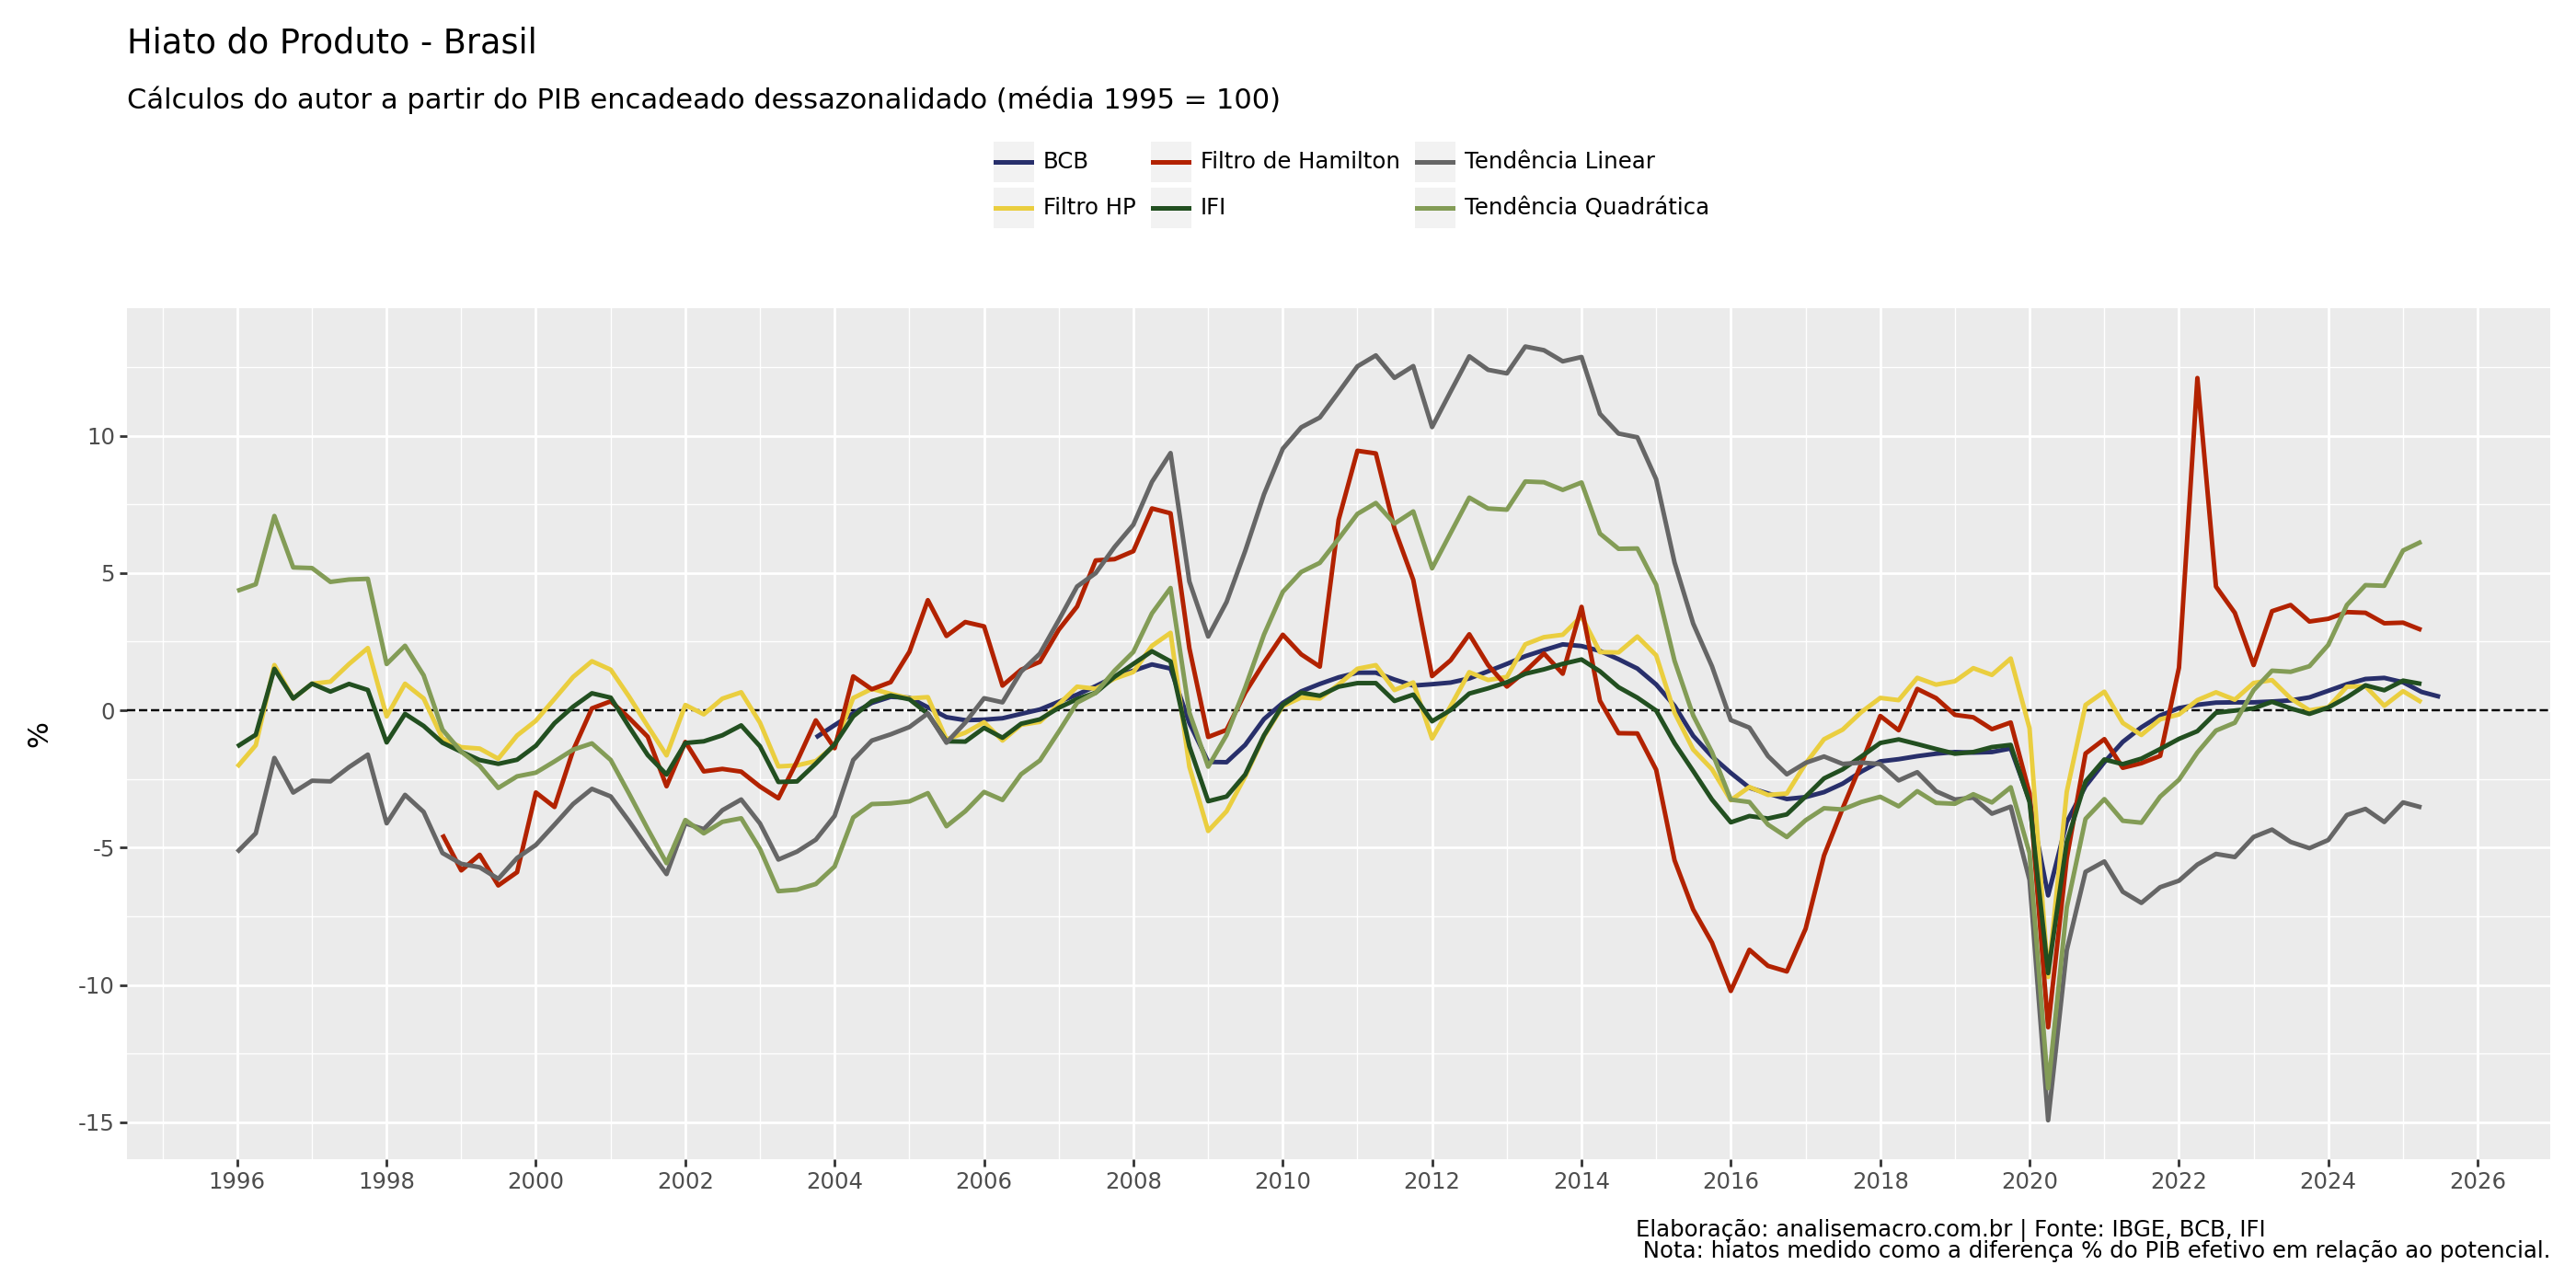

In [ ]:
(
    ggplot(dados_long) +
    aes(x='data', y='valor', color='variavel') +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_line(size=1) +
    scale_color_manual(values=list(colors.values())) +
    scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
    theme(legend_position='top',
          figure_size=(14, 7)) +
    labs(
        title="Hiato do Produto - Brasil",
        subtitle="Cálculos do autor a partir do PIB encadeado dessazonalidado (média 1995 = 100)",
        y="%",
        x='',
        color="",
        caption="Elaboração: analisemacro.com.br | Fonte: IBGE, BCB, IFI \n Nota: hiatos medido como a diferença % do PIB efetivo em relação ao potencial."
    )
)

## Estatística Descritivas dos Hiatos

Um ponto a se observar é do que as medidas de Hiato estimadas via Função de Produção (IFI e BCB) são menos voláteis, e possuem médias negativas, comparando-se às medidas de Tendências.



In [ ]:
dados.describe()

,Tendência Linear,Tendência Quadrática,Filtro HP,Filtro de Hamilton,IFI,BCB
count,118.000000,118.000000,118.000000,107.000000,118.000000,88.000000
mean,0.199489,0.100582,0.015453,0.092560,-0.704661,-0.230909
std,6.443992,4.513410,1.747205,4.302149,1.684910,1.678275
min,-14.926048,-13.760776,-9.710464,-11.539653,-9.570000,-6.740000
25%,-4.339424,-3.368379,-0.912010,-2.114577,-1.517500,-1.520000
50%,-2.291716,-1.319128,0.401578,0.443572,-0.560000,0.235000
75%,4.643244,4.550253,1.035043,2.928076,0.537500,0.972500
max,13.244719,8.330809,3.424672,12.098270,2.150000,2.400000
